In [1]:
%matplotlib inline

# DGL, a tutorial in MPNN
In this notebook, we shall implement a simple example of the Karate club, which is basically the MNIST of GNN.

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import dgl
import numpy as np
import torch
import sys
sys.path.append('./supportingexamples/')
import examples

## Drawing the graph of the problem
Below are drawings of the karate club interaction graph. We can observe that the club connections are centered around node 0 and node 33. I have used to different layouts. First the cycle layout that is similar to the graph in the original paper from the 1970s and then Kamada Kawai Layout, which gives us a more expressive graph. I have load the data using ```python networkx.karate_club_graph```

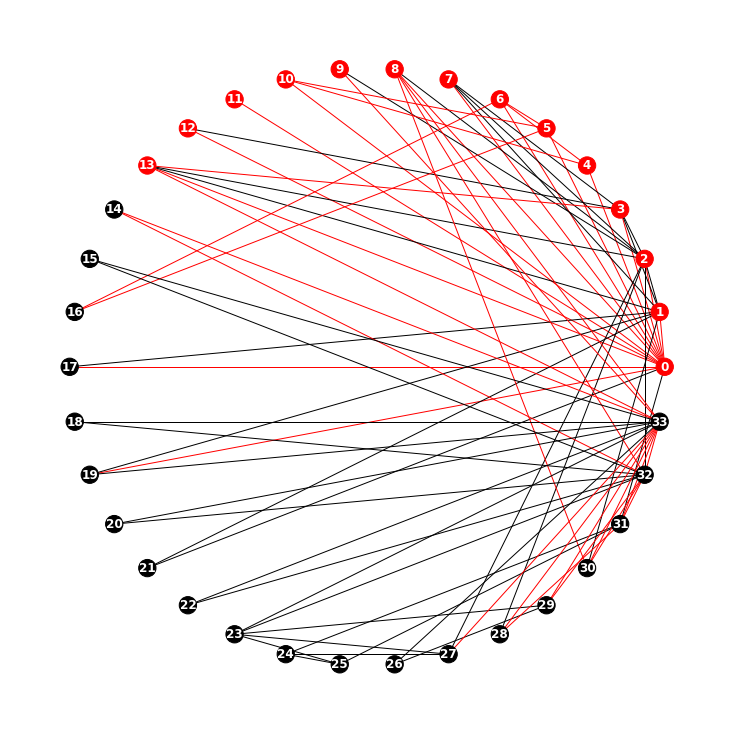

In [3]:
G = nx.karate_club_graph()
examples.draw_interaction_graph(G=G, pos='c')
# Alternatively swap the drawing function with the one below in order not to use the examples library I have created.
#nx.draw_circular(G, with_labels=True, font_weight='bold', node_color=red, font_color="white")


## Defining the graph
Since this notebook is all about using DGL to train the karate club network, let us create a DGL graph, using ```dgl.data.karate.KarateClub()``` . 
***note:*** *Please note that you need at least dgl version ```0.4.2``` for this to work. Older version do have a bug and return error. In oder to check your dgl version, please run ```dgl.__version__```.*

```dgl.data.karate.KarateClub()``` returns an object with two properties: data, and label. 'data' object is a python list with only one element of type ```dgl.DGLGraph```. data includes node labels. Node labels are either 1 or 0 with 1 indicating that the member, who is represented as a node, belongs to Mr. Hi's club.
'label' is a replica of ```KarateClub.data[0].nodes[:].data['label']```.

In [4]:
import dgl
G = dgl.from_networkx(G)
G, G.nodes(), G.edges()

(Graph(num_nodes=34, num_edges=156,
       ndata_schemes={}
       edata_schemes={}),
 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 (tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
           1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
           3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
           7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
          13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
          21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
          27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
          31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
          33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33]),
  tensor([ 1,  2,  3,  4,  5,  6,  7,  8, 

In order to make the edges more friendly to human reader, next I will present them as tuples.
A closer inspection of the edge list shows that for each edge $(v,w)$, there also exists an edge $(w,v)$. This is because ```dgl.DGLGraph``` is always directed. an undirected graph is represented as two directed graphs where $\mathcal{G} = (V,E)\ and\ \forall (v, w) \in E \iff (w, v) \in E$

In [5]:
src = G.edges()[0]
trg = G.edges()[1]
print([(a,b) for a,b in (zip(src.numpy(), trg.numpy()))])

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 0), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 0), (2, 1), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 0), (3, 1), (3, 2), (3, 7), (3, 12), (3, 13), (4, 0), (4, 6), (4, 10), (5, 0), (5, 6), (5, 10), (5, 16), (6, 0), (6, 4), (6, 5), (6, 16), (7, 0), (7, 1), (7, 2), (7, 3), (8, 0), (8, 2), (8, 30), (8, 32), (8, 33), (9, 2), (9, 33), (10, 0), (10, 4), (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2), (13, 3), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (16, 5), (16, 6), (17, 0), (17, 1), (18, 32), (18, 33), (19, 0), (19, 1), (19, 33), (20, 32), (20, 33), (21, 0), (21, 1), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 31), (25, 23), (25, 24), (25, 31), (26, 29), (26, 33), (27, 2), (27, 23), (27, 24), (27, 33), (28, 2), (28, 31)

We can observe that the graph has 34 nodes and 156 edges and presenyly neighther the nodes nor the edges have any attributes (`ndata_schemes == {} and edata_schemes == {}`). We can then add attribites to all ndoes as well as edges.
basically, we need to createa a tensors whose first axis (`axis==0`), matches the number of elements in node and edge list. For the nodes we are using `torch.nnEmbedding(34,5)`, which creates a tensor with shape of `(34,5)`. For edges, we simply use a randomg tensor with shape equal to `(156, 3)`. We then use `ndata['features']` and `edata['attributes]` in order to create attribites for nodes and edges that are respectively called `features` and `attributes`.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
embedding = nn.Embedding(34,5)
print(embedding.weight.shape, embedding.weight[0])
#creating a features label"
G.ndata['features'] = embedding.weight
G.ndata['features'][0]

torch.Size([34, 5]) tensor([-1.2850, -0.1855,  0.7054,  1.1698,  2.3627],
       grad_fn=<SelectBackward0>)


tensor([-1.2850, -0.1855,  0.7054,  1.1698,  2.3627],
       grad_fn=<SelectBackward0>)

## Defining a Graph Convolutional Network
For detailed information, plase refer to the [graph convolutional network](lnk) in the series. Essentially, at each layer, each node carries a feature vector. In our case, we have seen how a feature tensor is being created using using embedding `embedding = nn.Embedding(34,5)` and then assigned to the nodes. `DGL_G.ndata['features'] = embedding.weight`. You can observe that the size of the embedding tensort on `axis[0]` is 34 and matches the number of nodes.
The GCN, then agregates these features, using its neighborhood, before updating the next layer with its value. 
This is in keeping with the MPNN paradigm. For more details on MPNN, please refer to the [MPNN entry](link) from this series. Figure 1 visualizes the process.

<figure>
    <img src='images/mailbox.png'>
    <figurecaption> 
        
Figure1: MPNN paradigm. Next layer value for the hidden state of nove $v_1$ is the sum of current hidden values of its neighbors, passed through a function that can potentially be a neural network. the old value of the node itself is not included in the computation. Additoinally we should note that ther eis no need that we include only the immediate neighbors. We can design a definiion for what a neighbor it. We can consider to goo deeper or any other means that could help up have an effective embedding of the graph. 
    </figurecaption>
</figure>
    

In [7]:
from dgl.nn.pytorch import GraphConv
import torch.nn as nn
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h
    
net = GCN(5,5,2)
net

GCN(
  (conv1): GraphConv(in=5, out=5, normalization=both, activation=None)
  (conv2): GraphConv(in=5, out=2, normalization=both, activation=None)
)

As you have noticed, wach node as a feature that is an array of length 5, resulting  from `Embedding(34,5)`. This GCN, takes feature inputs of the size 5 and transforms it to a hidden size of 5 in the first layer. The second layer takes the hidden features of size 5 and generates an output the size of 2, corresponding to which membership each member is going to use. Obviously, if there were a third option, the output layer would have been of size 3. 


## Initializing the network
We now pass the data to the network to initialize the network before attemting to train it. First we use the node attributes as input data. We then define which nodes are labeled. Those are nodes `0`, representing the instructor, and node `33`, representing the club president. Finally we label the two nodes as `0` and `1` respectively. Finally, we can initialize the network using the inputs. We use the label information at the next step for training.

In [8]:
inputs = embedding.weight
labeled_nodes = torch.tensor([0, 33])  
labels = torch.tensor([0, 1]) 

In [9]:
net(G, inputs)

tensor([[-0.3374,  0.3154],
        [-0.2532,  0.1597],
        [-0.5593,  0.4393],
        [-0.4363,  0.1409],
        [ 0.2600,  0.3816],
        [ 0.0643,  0.4555],
        [-0.5810,  0.2677],
        [-0.1167,  0.0824],
        [-0.1502,  0.1563],
        [-0.1095,  0.0748],
        [-0.4852,  0.1647],
        [-0.1123,  0.0605],
        [-0.0546,  0.1206],
        [-0.1394,  0.1167],
        [-0.1304,  0.2094],
        [-0.1304,  0.2094],
        [-0.0344,  0.2563],
        [-0.1357,  0.0319],
        [-0.1304,  0.2094],
        [-0.1560,  0.0816],
        [-0.1304,  0.2094],
        [-0.1357,  0.0319],
        [-0.1304,  0.2094],
        [-0.6906,  0.5385],
        [-0.7794,  0.4198],
        [-0.3232,  0.1178],
        [-0.1424,  0.2149],
        [-0.3007,  0.1414],
        [-0.1547,  0.0767],
        [-0.3030,  0.3054],
        [-0.0975,  0.1418],
        [-0.5945,  0.4799],
        [-0.0693,  0.0658],
        [-0.4569,  0.3694]], grad_fn=<AddBackward0>)

## Training the network
We can now trian the netwrk using the input data and the labels. There are a few setting I would like to highlight before getting into the code:
1. We are using an Adam optimizer using ` torch.optim.Adam`, to which we pass an iterator chaining netwrk parameters, otained by `net.parameters()` and node label parameters optained by embedding.parameters(). We additoinally pass a learning rate of `0.01`
2.For loss function we are using a negative log likelihood loss obtained via `torch.nn.functional.nll_loss()` and pass the output of $softmax$ on `labeled_nodes` and `labels` to it. We are using the log likelihood for a classification problem with two classes, `instructor` and `president`. 

Next, let us explore what goes into the optimizer.

In [10]:
import itertools
optiam_params = itertools.chain(net.parameters(), embedding.parameters())
optiam_params.__next__()

Parameter containing:
tensor([[-0.5340,  0.5015, -0.2726,  0.7333,  0.1494],
        [-0.1700, -0.4509, -0.2489,  0.3216, -0.0144],
        [ 0.7049,  0.4724, -0.3158, -0.2444, -0.0796],
        [-0.1441,  0.2260, -0.6152, -0.4975, -0.1515],
        [-0.2843, -0.4554,  0.6432,  0.6919, -0.4815]], requires_grad=True)

In [11]:
optimizer = torch.optim.Adam(params=optiam_params, lr=0.01)

We can now train the network for 50 epochs

In [12]:
v_logits = []
for epoch in range(50):
    logits = net(G, inputs)
    v_logits.append(logits.detach())
    log_p = F.log_softmax(input=logits, dim=1) 
    loss = F.nll_loss(input=log_p[labeled_nodes], target=labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))    

Epoch 0 | Loss: 0.7175
Epoch 1 | Loss: 0.6903
Epoch 2 | Loss: 0.6654
Epoch 3 | Loss: 0.6424
Epoch 4 | Loss: 0.6217
Epoch 5 | Loss: 0.6044
Epoch 6 | Loss: 0.5873
Epoch 7 | Loss: 0.5698
Epoch 8 | Loss: 0.5521
Epoch 9 | Loss: 0.5341
Epoch 10 | Loss: 0.5157
Epoch 11 | Loss: 0.4968
Epoch 12 | Loss: 0.4777
Epoch 13 | Loss: 0.4585
Epoch 14 | Loss: 0.4392
Epoch 15 | Loss: 0.4200
Epoch 16 | Loss: 0.4009
Epoch 17 | Loss: 0.3821
Epoch 18 | Loss: 0.3635
Epoch 19 | Loss: 0.3453
Epoch 20 | Loss: 0.3274
Epoch 21 | Loss: 0.3099
Epoch 22 | Loss: 0.2928
Epoch 23 | Loss: 0.2760
Epoch 24 | Loss: 0.2596
Epoch 25 | Loss: 0.2438
Epoch 26 | Loss: 0.2287
Epoch 27 | Loss: 0.2143
Epoch 28 | Loss: 0.2006
Epoch 29 | Loss: 0.1875
Epoch 30 | Loss: 0.1752
Epoch 31 | Loss: 0.1636
Epoch 32 | Loss: 0.1527
Epoch 33 | Loss: 0.1425
Epoch 34 | Loss: 0.1330
Epoch 35 | Loss: 0.1240
Epoch 36 | Loss: 0.1156
Epoch 37 | Loss: 0.1079
Epoch 38 | Loss: 0.1007
Epoch 39 | Loss: 0.0938
Epoch 40 | Loss: 0.0874
Epoch 41 | Loss: 0.0815
Ep

/Users/cyrusmv/minicond/envs/dgl/lib/python3.9/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [13]:
(len(v_logits), len(v_logits[0]))

(50, 34)

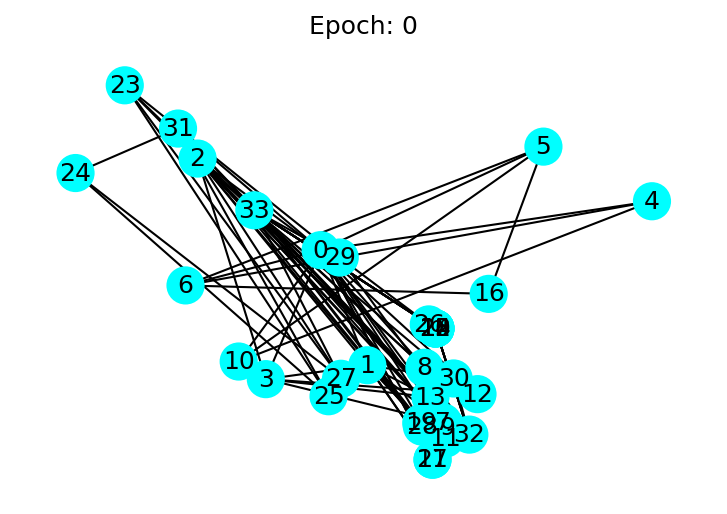

In [14]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
nx_G = G.to_networkx().to_undirected()

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = v_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch


The following animation shows how the model correctly predicts the community
after a series of training epochs.



In [15]:
ani = animation.FuncAnimation(fig, draw, frames=len(v_logits), interval=200)

![](https://data.dgl.ai/tutorial/1_first/karate.gif)

   :height: 300px
   :width: 400px
   :align: center



Next steps
----------

In the :doc:`next tutorial <2_basics>`, we will go through some more basics
of DGL, such as reading and writing node/edge features.

